In [1]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm
import matplotlib.pyplot as pp
import numpy as np

from sigma_graph.data.file_manager import check_dir, find_file_in_dir, load_graph_files
import matplotlib.pyplot as plt
import networkx as nx
import wandb

In [2]:
INPUT_DIMS = 27
OUTPUT_DIMS = 5
NUM_EPOCHS = 500000
TRAJECTORY_LENGTH = 5
BATCH_SIZE = 100
START_NODE = 24
LEARNING_RATE = 3e-4
GOAL_STATE = 17

transitions = {
    # 0: no-op 
    # 1: N 
    # 2: S 
    # 3: W
    # 4: E
    1: {0: 1, 1: 2, 2: 1, 3: 3, 4: 1},
    2: {0: 2, 1: 12, 2: 1, 3: 2, 4: 2},
    3: {0: 3, 1: 3, 2: 3, 3: 4, 4: 1},
    4: {0: 4, 1: 5, 2: 4, 3: 6, 4: 3},
    5: {0: 5, 1: 13, 2: 4, 3: 5, 4: 5},
    6: {0: 6, 1: 6, 2: 6, 3: 7, 4: 4},
    7: {0: 7, 1: 8, 2: 7, 3: 9, 4: 6},
    8: {0: 8, 1: 14, 2: 7, 3: 8, 4: 8},
    9: {0: 9, 1: 9, 2: 9, 3: 10, 4: 7},
    10: {0: 10, 1: 11, 2: 10, 3: 10, 4: 9},
    11: {0: 11, 1: 15, 2: 10, 3: 16, 4: 11},
    12: {0: 12, 1: 18, 2: 2, 3: 12, 4: 12},
    13: {0: 13, 1: 19, 2: 5, 3: 13, 4: 13},
    14: {0: 14, 1: 20, 2: 8, 3: 14, 4: 14},
    15: {0: 15, 1: 21, 2: 11, 3: 17, 4: 15},
    16: {0: 16, 1: 17, 2: 16, 3: 16, 4: 11},
    17: {0: 17, 1: 22, 2: 16, 3: 23, 4: 15},
    18: {0: 18, 1: 18, 2: 12, 3: 25, 4: 18},
    19: {0: 19, 1: 19, 2: 13, 3: 26, 4: 25},
    20: {0: 20, 1: 20, 2: 14, 3: 27, 4: 26},
    21: {0: 21, 1: 21, 2: 15, 3: 22, 4: 27},
    22: {0: 22, 1: 22, 2: 17, 3: 24, 4: 21},
    23: {0: 23, 1: 24, 2: 17, 3: 23, 4: 17},
    24: {0: 24, 1: 22, 2: 23, 3: 24, 4: 22},
    25: {0: 25, 1: 25, 2: 25, 3: 19, 4: 18},
    26: {0: 26, 1: 26, 2: 26, 3: 20, 4: 19},
    27: {0: 27, 1: 27, 2: 27, 3: 21, 4: 20}
}

def state_to_vec(state):
    result = [0]*27
    result[state-1] = 1
    return torch.tensor(result).float()

In [3]:
class TBModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()

    self.mlp_forward = nn.Sequential(nn.Linear(INPUT_DIMS, num_hid), 
                                     nn.LeakyReLU(),
                                     nn.Linear(num_hid, OUTPUT_DIMS))
    
    self.mlp_backward = nn.Sequential(nn.Linear(INPUT_DIMS, num_hid), 
                                      nn.LeakyReLU(),
                                      nn.Linear(num_hid, OUTPUT_DIMS))
    
    self.logZ = nn.Parameter(torch.ones(1))

  def forward(self, x):
    P_F = self.mlp_forward(x)
    return P_F
  
  def backward(self, x):
    P_B = torch.tensor([(1/INPUT_DIMS)]*INPUT_DIMS)#self.mlp_backward(x) 

    return P_B

In [4]:
# Very basic toy env 
goal_trajectory = [24, 22, 21, 27, 20, 14, 8, 7, 6, 4, 3, 1]

def compute_reward(trajectory):
    # reward = 0
    # for i in range(len(trajectory)):
    #     if trajectory[i] == goal_trajectory[i]:
    #         reward = reward + 1
    # return torch.tensor(reward)
    if trajectory[-1] == 17:
       return 1
    return 0

model = TBModel(512)
opt = torch.optim.Adam(model.parameters(),  3e-4)

tb_losses = []
tb_rewards = []
logZs = []

minibatch_loss = 0
minibatch_reward = 0

for episode in tqdm.tqdm(range(NUM_EPOCHS), ncols=40):
  state = START_NODE
  
  total_P_F = 0
  total_P_B = 0

  trajectory = []
  for t in range(TRAJECTORY_LENGTH):
    trajectory.append(state)
    P_F_s = model.forward(state_to_vec(state))
    P_B_s = model.backward(state_to_vec(state))

    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    new_state = transitions[state][action.item()]
    total_P_F += cat.log_prob(action)

    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    state = new_state

  reward = compute_reward(trajectory)
  loss = (model.logZ + total_P_F - torch.log(reward).clip(-20) - total_P_B).pow(2)
  minibatch_loss += loss
  minibatch_reward += reward

  if (episode + 1) % BATCH_SIZE == 0:
    tb_losses.append(minibatch_loss.item())
    tb_rewards.append(minibatch_reward.item()/BATCH_SIZE)
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    minibatch_reward = 0
    logZs.append(model.logZ.item())

100%|█| 100000/100000 [03:38<00:00, 458.


Text(0, 0.5, 'rewards')

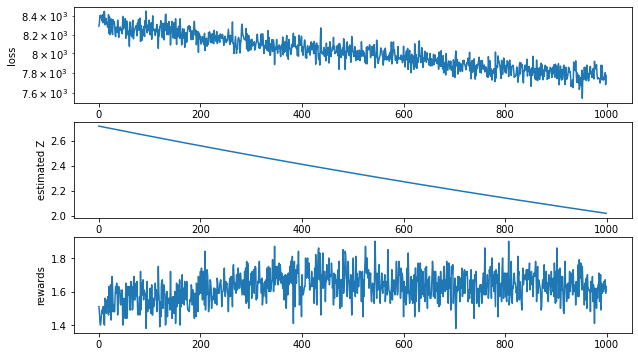

In [5]:
f, ax = pp.subplots(3, 1, figsize=(10,6))
pp.sca(ax[0])
pp.plot(tb_losses)
pp.yscale('log')
pp.ylabel('loss')
pp.sca(ax[1])
pp.plot(np.exp(logZs))
pp.ylabel('estimated Z')
pp.sca(ax[2])
pp.plot(tb_rewards)
pp.ylabel('rewards')

In [10]:
state = START_NODE

for t in range(TRAJECTORY_LENGTH):
    print(f'state {state}')
    P_F_s = model.forward(state_to_vec(state))
    P_B_s = model.backward(state_to_vec(state))

    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    new_state = transitions[state][action.item()]
    total_P_F += cat.log_prob(action)

    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    state = new_state

state 24
state 22
state 17
state 23
state 17


In [7]:
hit = 0
for i in range(1000):
    state = START_NODE
    for t in range(TRAJECTORY_LENGTH):
        P_F_s = model.forward(state_to_vec(state))
        P_B_s = model.backward(state_to_vec(state))

        cat = Categorical(logits=P_F_s)
        action = cat.sample()
        new_state = transitions[state][action.item()]
        total_P_F += cat.log_prob(action)

        total_P_B += Categorical(logits=P_B_s).log_prob(action)

        state = new_state

    if state == 17:
        hit = hit + 1
print(hit/1000)

0.169


flows {'NOOP': -0.05195204168558121, 'N': 0.04991013929247856, 'S': 0.15098094940185547, 'W': -0.14517651498317719, 'E': 0.1809293031692505}
flows {'NOOP': -0.04657095670700073, 'N': 0.036689672619104385, 'S': 0.14983463287353516, 'W': -0.1651303768157959, 'E': 0.10345382988452911}
flows {'NOOP': -0.11088765412569046, 'N': 0.005800709128379822, 'S': 0.1961396187543869, 'W': -0.17822004854679108, 'E': 0.1826634258031845}


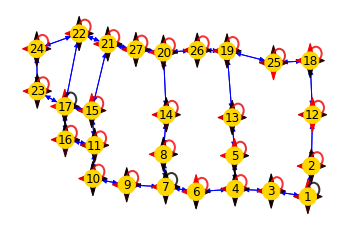

In [8]:
state_dirs = {}
for node in range(27):
    probs = model.forward(state_to_vec(node))
    # 0: no-op 
    # 1: N 
    # 2: S 
    # 3: W
    # 4: E
    total_probs = {}
    total_probs["NOOP"] = (probs[0]).tolist()
    total_probs["N"] = (probs[1]).tolist()
    total_probs["S"] = (probs[2]).tolist()
    total_probs["W"] = (probs[3]).tolist()
    total_probs["E"] = (probs[4]).tolist()
 

    state_dirs[node] = total_probs

flows = state_dirs
print(f'flows {flows[23]}')
print(f'flows {flows[18]}')
print(f'flows {flows[15]}')
map_info, _ = load_graph_files(map_lookup="S")

fig = plt.figure()
fig.patch.set_alpha(0.)
fig.tight_layout()

plt.axis('off')

col_map = ["gold"] * len(map_info.n_info)

nx.draw_networkx(map_info.g_acs, map_info.n_info, node_color=col_map, edge_color="blue", arrows=True)

max_x = max(pos[0] for pos in map_info.n_info.values())
max_y = max(pos[1] for pos in map_info.n_info.values())
scale_factor = max(max_x, max_y) / 2000
op_to_dir = {
    'N': (0, 1), 
    'S': (0, -1), 
    'W': (-1, 0),
    'E': (1, 0)
}
for node in map_info.g_acs.nodes:
    pos = map_info.n_info[node]
    x, y = pos
    dir_flows = flows[node-1]

    color_vals = np.linspace(0, 1.00, 100)
    colors = [(color, 0, 0, 0) for color in color_vals]

    for op in ['N', 'S', 'W', 'E']:
        flow = int((dir_flows[op]) * 99)
        dx, dy = op_to_dir[op]
        plt.arrow(x, y, dx*scale_factor, dy*scale_factor, color=colors[flow], alpha=1, width=0.1, head_width=1)

    circle_radius = 1.00 
    circle_center_x = x + circle_radius  
    circle_center_y = y + circle_radius 

    flow = int((dir_flows['NOOP']) * 99)

    circle = plt.Circle((circle_center_x, circle_center_y), circle_radius, color=colors[flow], alpha=0.8, fill=False, linewidth=2)

    plt.gca().add_patch(circle)


In [9]:
flows 
{0: {'NOOP': -0.04281928390264511, 'N': -0.7044185400009155, 'S': 0.8365095853805542, 'W': -0.294208288192749, 'E': -0.0060260482132434845}, 
 1: {'NOOP': -0.06572075188159943, 'N': -0.8022883534431458, 'S': 0.7774446606636047, 'W': -0.23733994364738464, 'E': -0.21175378561019897}, 
 2: {'NOOP': -0.15315857529640198, 'N': -0.8222216963768005, 'S': 0.9140884280204773, 'W': -0.20453889667987823, 'E': -0.2380082607269287}, 
 3: {'NOOP': -0.15023279190063477, 'N': -0.7378121614456177, 'S': 0.8891063332557678, 'W': -0.09142963588237762, 'E': -0.24385100603103638}, 
 4: {'NOOP': -0.07206474989652634, 'N': -1.0085142850875854, 'S': 0.9080254435539246, 'W': 0.5623538494110107, 'E': -0.8295060396194458}, 
 5: {'NOOP': -0.17401105165481567, 'N': -1.0206310749053955, 'S': 1.168321132659912, 'W': -0.31326058506965637, 'E': -0.29284152388572693}, 
 6: {'NOOP': 0.29616788029670715, 'N': -0.6765700578689575, 'S': 1.7027835845947266, 'W': -0.7930687665939331, 'E': -0.9280052185058594}, 
 7: {'NOOP': -0.18688106536865234, 'N': -1.0172914266586304, 'S': 0.8644939064979553, 'W': -0.6106293201446533, 'E': 0.5325061082839966}, 
 8: {'NOOP': -0.04091595858335495, 'N': -0.8219321370124817, 'S': 1.088913083076477, 'W': -0.28339526057243347, 'E': -0.32663142681121826}, 
 9: {'NOOP': -0.08009160310029984, 'N': -0.7991769313812256, 'S': 0.7578392624855042, 'W': -0.4435887336730957, 'E': -0.05031454563140869}, 
 10: {'NOOP': -0.03729896992444992, 'N': -0.8757666349411011, 'S': 1.041592001914978, 'W': -0.47257521748542786, 'E': -0.15408331155776978}, 11: {'NOOP': -0.06113097816705704, 'N': -0.7633384466171265, 'S': 1.0141456127166748, 'W': -0.3527575731277466, 'E': -0.3120118975639343}, 12: {'NOOP': -0.00613616406917572, 'N': -0.7722690105438232, 'S': 0.938063383102417, 'W': -0.2874240577220917, 'E': -0.3028886318206787}, 13: {'NOOP': -0.1158658042550087, 'N': -0.9718967080116272, 'S': 1.1266144514083862, 'W': -0.3259008824825287, 'E': -0.30215832591056824}, 14: {'NOOP': -0.15581300854682922, 'N': -0.9797416925430298, 'S': 1.1761813163757324, 'W': -0.27505865693092346, 'E': -0.4173281788825989}, 15: {'NOOP': 0.04006331041455269, 'N': -0.7302824258804321, 'S': 0.9193851947784424, 'W': -0.28476497530937195, 'E': -0.3234466314315796}, 16: {'NOOP': -0.028649136424064636, 'N': -0.7955811619758606, 'S': 0.8990495800971985, 'W': -0.18944144248962402, 'E': -0.26828718185424805}, 17: {'NOOP': -0.03757932037115097, 'N': -0.7265559434890747, 'S': 0.9418012499809265, 'W': -0.3114413321018219, 'E': -0.2813953459262848}, 18: {'NOOP': 0.07390851527452469, 'N': -0.7424029111862183, 'S': 1.0141987800598145, 'W': -0.29449424147605896, 'E': -0.34659188985824585}, 19: {'NOOP': -0.1182183101773262, 'N': -0.9873968362808228, 'S': 1.3456995487213135, 'W': -0.40572383999824524, 'E': -0.5384065508842468}, 20: {'NOOP': 0.011343080550432205, 'N': -0.7675076127052307, 'S': 1.1061038970947266, 'W': -0.49046817421913147, 'E': -0.3443695902824402}, 21: {'NOOP': -0.09412992745637894, 'N': -0.8214873671531677, 'S': 0.954239547252655, 'W': -0.25977054238319397, 'E': -0.19500136375427246}, 22: {'NOOP': -0.034168392419815063, 'N': -0.8640755414962769, 'S': 0.9225086569786072, 'W': -0.20460711419582367, 'E': -0.21131184697151184}, 23: {'NOOP': -0.06955473870038986, 'N': -0.7043285369873047, 'S': 0.9922298789024353, 'W': -0.3274853527545929, 'E': -0.18804946541786194}, 24: {'NOOP': -0.09201907366514206, 'N': -0.7363082766532898, 'S': 0.9292238354682922, 'W': -0.2653632164001465, 'E': -0.21761581301689148}, 25: {'NOOP': -0.08425996452569962, 'N': -0.745369553565979, 'S': 0.8916536569595337, 'W': -0.31660374999046326, 'E': -0.2894901633262634}, 26: {'NOOP': -0.12031040340662003, 'N': -0.7619705200195312, 'S': 0.6998625993728638, 'W': -0.23402869701385498, 'E': -0.0803600326180458}}


{0: {'NOOP': -0.04281928390264511,
  'N': -0.7044185400009155,
  'S': 0.8365095853805542,
  'W': -0.294208288192749,
  'E': -0.0060260482132434845},
 1: {'NOOP': -0.06572075188159943,
  'N': -0.8022883534431458,
  'S': 0.7774446606636047,
  'W': -0.23733994364738464,
  'E': -0.21175378561019897},
 2: {'NOOP': -0.15315857529640198,
  'N': -0.8222216963768005,
  'S': 0.9140884280204773,
  'W': -0.20453889667987823,
  'E': -0.2380082607269287},
 3: {'NOOP': -0.15023279190063477,
  'N': -0.7378121614456177,
  'S': 0.8891063332557678,
  'W': -0.09142963588237762,
  'E': -0.24385100603103638},
 4: {'NOOP': -0.07206474989652634,
  'N': -1.0085142850875854,
  'S': 0.9080254435539246,
  'W': 0.5623538494110107,
  'E': -0.8295060396194458},
 5: {'NOOP': -0.17401105165481567,
  'N': -1.0206310749053955,
  'S': 1.168321132659912,
  'W': -0.31326058506965637,
  'E': -0.29284152388572693},
 6: {'NOOP': 0.29616788029670715,
  'N': -0.6765700578689575,
  'S': 1.7027835845947266,
  'W': -0.793068766593

In [4]:
wandb.init(
    project="graph-training-simulation",
    config={
            "exp_config": {
                "learning_rate": LEARNING_RATE,
                "epocs": NUM_EPOCHS,
                "batch_size": BATCH_SIZE
        }
    },
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: r-marr747. Use `wandb login --relogin` to force relogin


In [10]:
# Very basic toy env 
class TBModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()

    self.mlp_forward = nn.Sequential(nn.Linear(TRAJECTORY_LENGTH, num_hid), 
                                     nn.LeakyReLU(),
                                     nn.Linear(num_hid, OUTPUT_DIMS))
    
    self.mlp_backward = nn.Sequential(nn.Linear(TRAJECTORY_LENGTH, num_hid), 
                                      nn.LeakyReLU(),
                                      nn.Linear(num_hid, OUTPUT_DIMS))
    
    self.logZ = nn.Parameter(torch.ones(1))

  def forward(self, x):
    P_F = self.mlp_forward(x)
    return P_F
  
  def backward(self, x):
    P_B = torch.tensor([(1/INPUT_DIMS)]*INPUT_DIMS)#self.mlp_backward(x) 

    return P_B
  
goal_trajectory = [24, 22, 21, 27, 20, 14, 8, 7, 6, 4, 3, 1]
def compute_reward(trajectory):
    # reward = 0
    # for i in range(len(trajectory)):
    #     if trajectory[i] == goal_trajectory[i]:
    #         reward = reward + 1
    # return torch.tensor(reward)
    if trajectory[-1] == 17:
      return torch.tensor([1])
    return torch.tensor([0])

model = TBModel(512)
opt = torch.optim.Adam(model.parameters(),  3e-4)

tb_losses = []
tb_rewards = []
logZs = []

minibatch_loss = 0
minibatch_reward = 0

for episode in tqdm.tqdm(range(NUM_EPOCHS), ncols=40):
  
  gflow_state = torch.zeros(TRAJECTORY_LENGTH)
  state = START_NODE

  total_P_F = 0
  total_P_B = 0

  trajectory = []
  for t in range(TRAJECTORY_LENGTH):
    trajectory.append(state)
    P_F_s = model.forward(gflow_state)
    P_B_s = model.backward(gflow_state)

    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    _gflow_state = gflow_state.clone()
    _gflow_state[t] = action
    gflow_state = _gflow_state.clone()

    new_state = transitions[state][action.item()]
    total_P_F += cat.log_prob(action)

    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    state = new_state

  reward = compute_reward(trajectory)

  loss = (model.logZ + total_P_F - torch.log(reward).clip(-20) - total_P_B).pow(2)
  
  minibatch_loss += loss
  minibatch_reward += reward

  if (episode + 1) % BATCH_SIZE == 0:
    wandb.log({
      "loss": minibatch_loss.item(),
      "reward": minibatch_reward.item()/BATCH_SIZE,
      "Z": model.logZ.item()
    })
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    minibatch_reward = 0

  0%| | 52/500000 [00:00<16:09, 515.71it

[24, 24, 24, 23, 24]
24
[24, 24, 23, 17, 15]
15
[24, 22, 21, 22, 22]
22
[24, 23, 17, 17, 23]
23
[24, 22, 17, 22, 21]
21
[24, 24, 23, 23, 23]
23
[24, 24, 22, 21, 27]
27
[24, 24, 24, 23, 17]
17
[24, 23, 17, 23, 23]
23
[24, 22, 22, 22, 24]
24
[24, 24, 24, 24, 22]
22
[24, 24, 22, 21, 22]
22
[24, 24, 24, 24, 23]
23
[24, 24, 22, 21, 15]
15
[24, 24, 24, 23, 17]
17
[24, 22, 21, 22, 17]
17
[24, 24, 22, 24, 24]
24
[24, 23, 23, 23, 23]
23
[24, 24, 22, 22, 22]
22
[24, 22, 22, 22, 22]
22
[24, 22, 24, 24, 23]
23
[24, 22, 22, 24, 22]
22
[24, 24, 22, 21, 21]
21
[24, 24, 23, 17, 22]
22
[24, 23, 17, 17, 15]
15
[24, 24, 24, 24, 23]
23
[24, 24, 22, 17, 23]
23
[24, 23, 23, 24, 24]
24
[24, 23, 23, 17, 17]
17
[24, 22, 21, 27, 21]
21
[24, 23, 23, 23, 23]
23
[24, 23, 17, 17, 17]
17
[24, 22, 22, 22, 21]
21
[24, 24, 24, 24, 24]
24
[24, 22, 17, 16, 11]
11
[24, 23, 17, 15, 11]
11
[24, 22, 21, 21, 15]
15
[24, 22, 22, 22, 17]
17
[24, 22, 22, 24, 22]
22
[24, 24, 22, 22, 22]
22
[24, 24, 22, 21, 21]
21
[24, 24, 22, 22,

  0%| | 157/500000 [00:00<18:40, 446.27i

[24, 24, 24, 24, 24]
24
[24, 22, 24, 24, 24]
24
[24, 23, 24, 23, 24]
24
[24, 22, 17, 17, 16]
16
[24, 24, 24, 22, 22]
22
[24, 22, 22, 24, 23]
23
[24, 22, 17, 17, 16]
16
[24, 22, 22, 17, 15]
15
[24, 23, 17, 22, 17]
17
[24, 22, 24, 22, 24]
24
[24, 23, 24, 22, 22]
22
[24, 22, 21, 21, 21]
21
[24, 22, 22, 17, 22]
22
[24, 22, 17, 15, 17]
17
[24, 22, 24, 24, 24]
24
[24, 22, 22, 22, 22]
22
[24, 24, 24, 23, 24]
24
[24, 22, 24, 24, 24]
24
[24, 22, 24, 24, 24]
24
[24, 22, 22, 21, 15]
15
[24, 24, 22, 17, 17]
17
[24, 22, 22, 24, 23]
23
[24, 24, 24, 24, 23]
23
[24, 22, 17, 16, 16]
16
[24, 22, 22, 21, 21]
21
[24, 24, 22, 17, 22]
22
[24, 24, 24, 23, 23]
23
[24, 24, 22, 22, 24]
24
[24, 22, 21, 21, 21]
21
[24, 24, 24, 23, 17]
17
[24, 24, 22, 21, 21]
21
[24, 22, 22, 17, 16]
16
[24, 24, 23, 24, 24]
24
[24, 24, 24, 22, 22]
22
[24, 24, 22, 17, 16]
16
[24, 24, 24, 24, 24]
24
[24, 24, 24, 22, 21]
21
[24, 24, 24, 24, 22]
22
[24, 22, 22, 22, 22]
22
[24, 24, 24, 23, 23]
23
[24, 24, 22, 17, 17]
17
[24, 23, 17, 23,

  0%| | 256/500000 [00:00<19:14, 433.01i

[24, 24, 23, 23, 23]
23
[24, 22, 22, 17, 17]
17
[24, 24, 22, 22, 24]
24
[24, 24, 22, 17, 22]
22
[24, 23, 17, 16, 16]
16
[24, 24, 24, 24, 23]
23
[24, 24, 23, 23, 17]
17
[24, 22, 17, 15, 17]
17
[24, 22, 24, 22, 22]
22
[24, 24, 24, 24, 24]
24
[24, 22, 17, 22, 24]
24
[24, 23, 23, 23, 23]
23
[24, 22, 24, 24, 24]
24
[24, 24, 22, 21, 21]
21
[24, 22, 22, 24, 22]
22
[24, 23, 24, 22, 21]
21
[24, 22, 22, 24, 24]
24
[24, 24, 22, 24, 24]
24
[24, 22, 21, 21, 21]
21
[24, 24, 23, 23, 17]
17
[24, 23, 24, 24, 22]
22
[24, 23, 17, 17, 16]
16
[24, 22, 24, 24, 24]
24
[24, 24, 24, 24, 24]
24
[24, 22, 17, 22, 22]
22
[24, 22, 24, 24, 22]
22
[24, 24, 23, 24, 24]
24
[24, 24, 24, 24, 22]
22
[24, 24, 24, 22, 22]
22
[24, 22, 21, 15, 17]
17
[24, 24, 24, 23, 23]
23
[24, 22, 21, 15, 17]
17
[24, 22, 21, 21, 22]
22
[24, 23, 23, 17, 15]
15
[24, 22, 17, 17, 23]
23
[24, 24, 22, 22, 22]
22
[24, 23, 23, 23, 23]
23
[24, 24, 22, 21, 27]
27
[24, 23, 17, 17, 23]
23
[24, 23, 23, 23, 17]
17
[24, 24, 22, 24, 24]
24
[24, 23, 23, 23,

  0%| | 353/500000 [00:00<19:27, 428.11i

[24, 23, 17, 16, 16]
16
[24, 23, 17, 23, 17]
17
[24, 24, 23, 23, 17]
17
[24, 23, 17, 23, 23]
23
[24, 24, 22, 24, 22]
22
[24, 22, 17, 17, 17]
17
[24, 24, 22, 24, 22]
22
[24, 24, 24, 24, 24]
24
[24, 22, 22, 21, 15]
15
[24, 23, 17, 16, 16]
16
[24, 22, 22, 22, 22]
22
[24, 24, 24, 23, 23]
23
[24, 24, 23, 23, 24]
24
[24, 23, 17, 23, 23]
23
[24, 22, 22, 24, 24]
24
[24, 24, 24, 24, 23]
23
[24, 22, 22, 22, 22]
22
[24, 22, 22, 24, 23]
23
[24, 22, 17, 16, 16]
16
[24, 22, 22, 22, 22]
22
[24, 23, 23, 23, 17]
17
[24, 24, 23, 23, 17]
17
[24, 23, 23, 23, 23]
23
[24, 24, 22, 22, 21]
21
[24, 22, 17, 17, 17]
17
[24, 23, 23, 17, 16]
16
[24, 22, 24, 22, 21]
21
[24, 24, 22, 24, 24]
24
[24, 23, 17, 15, 15]
15
[24, 22, 22, 22, 22]
22
[24, 24, 23, 17, 16]
16
[24, 24, 24, 24, 22]
22
[24, 24, 24, 22, 22]
22
[24, 23, 23, 23, 23]
23
[24, 24, 24, 22, 24]
24
[24, 22, 24, 24, 24]
24
[24, 22, 21, 27, 27]
27
[24, 24, 23, 23, 23]
23
[24, 22, 24, 24, 23]
23
[24, 22, 21, 22, 22]
22
[24, 24, 24, 22, 17]
17
[24, 24, 23, 17,

  0%| | 451/500000 [00:01<19:35, 424.82i

[24, 22, 22, 22, 22]
22
[24, 24, 22, 22, 17]
17
[24, 22, 21, 21, 21]
21
[24, 24, 22, 24, 24]
24
[24, 22, 17, 15, 21]
21
[24, 23, 24, 24, 24]
24
[24, 22, 22, 21, 15]
15
[24, 22, 24, 22, 22]
22
[24, 24, 22, 22, 22]
22
[24, 22, 24, 23, 23]
23
[24, 22, 21, 22, 22]
22
[24, 22, 21, 27, 27]
27
[24, 24, 24, 24, 23]
23
[24, 24, 22, 21, 15]
15
[24, 22, 17, 17, 17]
17
[24, 23, 17, 15, 15]
15
[24, 24, 23, 23, 17]
17
[24, 24, 22, 21, 21]
21
[24, 22, 17, 17, 23]
23
[24, 24, 22, 17, 17]
17
[24, 22, 22, 22, 24]
24
[24, 24, 22, 24, 24]
24
[24, 23, 23, 23, 23]
23
[24, 22, 21, 27, 27]
27
[24, 24, 23, 17, 17]
17
[24, 23, 17, 17, 17]
17
[24, 22, 24, 24, 22]
22
[24, 24, 24, 24, 22]
22
[24, 24, 23, 23, 24]
24
[24, 24, 24, 22, 21]
21
[24, 22, 21, 15, 17]
17
[24, 22, 24, 22, 17]
17
[24, 23, 17, 15, 15]
15
[24, 23, 23, 24, 24]
24
[24, 22, 22, 24, 24]
24
[24, 24, 24, 24, 24]
24
[24, 22, 22, 22, 22]
22
[24, 24, 24, 24, 23]
23
[24, 22, 22, 22, 21]
21
[24, 23, 23, 23, 23]
23
[24, 23, 23, 23, 17]
17
[24, 24, 24, 22,

  0%| | 598/500000 [00:01<18:54, 440.07i

[24, 22, 22, 24, 22]
22
[24, 22, 24, 23, 23]
23
[24, 22, 22, 24, 23]
23
[24, 23, 17, 15, 15]
15
[24, 24, 24, 24, 23]
23
[24, 22, 22, 22, 24]
24
[24, 24, 24, 24, 24]
24
[24, 22, 17, 23, 23]
23
[24, 22, 22, 17, 16]
16
[24, 22, 22, 22, 17]
17
[24, 24, 22, 24, 24]
24
[24, 24, 24, 22, 21]
21
[24, 22, 21, 22, 24]
24
[24, 22, 22, 21, 15]
15
[24, 22, 17, 22, 22]
22
[24, 22, 17, 23, 17]
17
[24, 22, 22, 22, 21]
21
[24, 24, 23, 23, 17]
17
[24, 24, 24, 23, 17]
17
[24, 22, 21, 15, 15]
15
[24, 22, 21, 21, 21]
21
[24, 23, 17, 17, 17]
17
[24, 24, 24, 22, 21]
21
[24, 23, 17, 23, 17]
17
[24, 22, 17, 16, 16]
16
[24, 23, 23, 17, 15]
15
[24, 22, 17, 23, 23]
23
[24, 22, 17, 16, 17]
17
[24, 22, 22, 22, 22]
22
[24, 22, 22, 21, 21]
21
[24, 22, 22, 22, 22]
22
[24, 23, 17, 17, 23]
23
[24, 24, 22, 22, 17]
17
[24, 23, 17, 23, 23]
23
[24, 23, 17, 23, 24]
24
[24, 24, 23, 17, 23]
23
[24, 23, 17, 23, 23]
23
[24, 22, 22, 22, 21]
21
[24, 22, 17, 17, 16]
16
[24, 23, 24, 24, 22]
22
[24, 24, 24, 24, 24]
24
[24, 24, 23, 24,

  0%| | 644/500000 [00:01<21:01, 395.86i

[24, 22, 22, 22, 22]
22
[24, 22, 17, 16, 16]
16
[24, 24, 22, 22, 21]
21
[24, 24, 23, 23, 17]
17
[24, 23, 24, 24, 22]
22
[24, 24, 22, 22, 22]
22
[24, 24, 24, 22, 22]
22
[24, 24, 24, 24, 24]
24
[24, 24, 23, 23, 17]
17
[24, 24, 22, 24, 24]
24
[24, 23, 17, 17, 23]
23
[24, 24, 22, 24, 22]
22
[24, 24, 24, 24, 24]
24
[24, 23, 23, 24, 22]
22
[24, 24, 22, 24, 23]
23
[24, 22, 21, 27, 27]
27
[24, 24, 24, 24, 23]
23
[24, 22, 22, 22, 24]
24
[24, 22, 21, 22, 24]
24
[24, 24, 22, 24, 22]
22
[24, 24, 22, 21, 21]
21
[24, 22, 17, 16, 16]
16
[24, 24, 24, 22, 24]
24
[24, 24, 24, 24, 23]
23
[24, 23, 23, 23, 23]
23
[24, 24, 23, 23, 23]
23
[24, 24, 23, 24, 24]
24
[24, 24, 23, 17, 15]
15
[24, 22, 24, 24, 22]
22
[24, 24, 22, 21, 15]
15
[24, 24, 24, 23, 24]
24
[24, 24, 22, 17, 16]
16
[24, 24, 23, 23, 17]
17
[24, 23, 23, 17, 23]
23
[24, 22, 21, 27, 21]
21
[24, 22, 24, 22, 22]
22
[24, 23, 17, 16, 16]
16
[24, 24, 22, 22, 17]
17
[24, 24, 22, 17, 15]
15
[24, 22, 22, 22, 22]
22
[24, 22, 21, 22, 24]
24
[24, 24, 22, 22,

  0%| | 741/500000 [00:01<21:08, 393.57i

[24, 22, 24, 24, 23]
23
[24, 23, 17, 23, 17]
17
[24, 24, 22, 17, 16]
16
[24, 22, 22, 17, 17]
17
[24, 24, 24, 24, 22]
22
[24, 22, 22, 21, 22]
22
[24, 24, 23, 24, 24]
24
[24, 24, 24, 24, 24]
24
[24, 24, 24, 23, 24]
24
[24, 24, 22, 22, 24]
24
[24, 24, 23, 23, 24]
24
[24, 22, 22, 24, 22]
22
[24, 23, 17, 16, 16]
16
[24, 23, 23, 23, 23]
23
[24, 23, 17, 23, 17]
17
[24, 24, 22, 17, 23]
23
[24, 24, 23, 24, 22]
22
[24, 24, 23, 23, 23]
23
[24, 24, 22, 21, 21]
21
[24, 22, 21, 21, 21]
21
[24, 22, 24, 22, 24]
24
[24, 24, 23, 17, 16]
16
[24, 24, 22, 21, 15]
15
[24, 23, 24, 24, 24]
24
[24, 24, 23, 23, 23]
23
[24, 23, 23, 23, 17]
17
[24, 24, 24, 24, 23]
23
[24, 22, 17, 16, 16]
16
[24, 23, 24, 24, 24]
24
[24, 24, 24, 24, 24]
24
[24, 24, 22, 21, 21]
21
[24, 24, 22, 24, 22]
22
[24, 22, 17, 16, 16]
16
[24, 24, 24, 22, 22]
22
[24, 22, 21, 21, 22]
22
[24, 23, 23, 24, 23]
23
[24, 23, 17, 15, 11]
11
[24, 22, 22, 22, 22]
22
[24, 24, 22, 22, 17]
17
[24, 22, 22, 17, 22]
22
[24, 22, 24, 23, 23]
23
[24, 22, 22, 21,

  0%| | 793/500000 [00:01<19:33, 425.35i

[24, 24, 22, 22, 24]
24
[24, 24, 22, 17, 16]
16
[24, 24, 24, 24, 24]
24
[24, 24, 24, 24, 24]
24
[24, 22, 21, 21, 21]
21
[24, 22, 22, 22, 21]
21
[24, 24, 22, 22, 17]
17
[24, 23, 23, 17, 16]
16
[24, 24, 24, 22, 21]
21
[24, 24, 24, 24, 24]
24
[24, 22, 24, 24, 22]
22
[24, 23, 23, 17, 17]
17
[24, 24, 23, 23, 23]
23
[24, 22, 22, 22, 24]
24
[24, 24, 24, 22, 22]
22
[24, 24, 23, 23, 17]
17
[24, 24, 23, 24, 24]
24
[24, 22, 24, 24, 22]
22
[24, 24, 22, 22, 24]
24
[24, 24, 22, 21, 27]
27
[24, 23, 24, 22, 17]
17
[24, 22, 22, 24, 23]
23
[24, 24, 23, 24, 22]
22
[24, 22, 17, 16, 16]
16
[24, 24, 24, 22, 17]
17
[24, 24, 24, 24, 23]
23
[24, 23, 24, 22, 17]
17
[24, 22, 21, 15, 15]
15
[24, 22, 22, 24, 24]
24
[24, 24, 24, 24, 24]
24
[24, 22, 22, 17, 23]
23
[24, 24, 24, 23, 24]
24
[24, 24, 23, 23, 23]
23
[24, 22, 17, 23, 24]
24
[24, 24, 22, 21, 15]
15
[24, 22, 17, 17, 23]
23
[24, 24, 22, 21, 15]
15
[24, 24, 24, 24, 24]
24
[24, 22, 22, 22, 17]
17
[24, 22, 17, 23, 23]
23
[24, 24, 23, 23, 23]
23
[24, 24, 22, 22,

  0%| | 889/500000 [00:02<19:33, 425.19i

[24, 22, 24, 24, 22]
22
[24, 24, 24, 22, 22]
22
[24, 23, 24, 24, 23]
23
[24, 22, 22, 22, 17]
17
[24, 24, 24, 24, 24]
24
[24, 23, 23, 23, 23]
23
[24, 22, 24, 24, 24]
24
[24, 24, 22, 21, 27]
27
[24, 23, 23, 17, 16]
16
[24, 22, 22, 22, 17]
17
[24, 23, 24, 24, 23]
23
[24, 23, 17, 16, 16]
16
[24, 23, 24, 24, 24]
24
[24, 24, 24, 23, 23]
23
[24, 24, 22, 21, 21]
21
[24, 22, 22, 24, 22]
22
[24, 22, 24, 23, 23]
23
[24, 22, 21, 27, 27]
27
[24, 24, 22, 21, 15]
15
[24, 24, 24, 24, 24]
24
[24, 23, 17, 23, 17]
17
[24, 23, 24, 22, 21]
21
[24, 22, 24, 24, 22]
22
[24, 22, 22, 22, 21]
21
[24, 22, 22, 22, 22]
22
[24, 24, 22, 24, 24]
24
[24, 23, 23, 23, 17]
17
[24, 22, 21, 21, 22]
22
[24, 24, 24, 24, 22]
22
[24, 24, 24, 24, 22]
22
[24, 24, 24, 24, 22]
22
[24, 23, 17, 16, 17]
17
[24, 24, 22, 22, 17]
17
[24, 24, 24, 23, 23]
23
[24, 24, 23, 17, 17]
17
[24, 22, 24, 24, 24]
24
[24, 24, 24, 24, 22]
22
[24, 24, 22, 21, 15]
15
[24, 22, 17, 23, 24]
24
[24, 24, 23, 23, 23]
23
[24, 22, 17, 23, 17]
17
[24, 22, 17, 15,

  0%| | 986/500000 [00:02<19:35, 424.59i

[24, 22, 21, 21, 15]
15
[24, 23, 17, 17, 23]
23
[24, 24, 22, 24, 24]
24
[24, 22, 21, 21, 21]
21
[24, 23, 23, 23, 24]
24
[24, 24, 23, 23, 17]
17
[24, 24, 24, 24, 24]
24
[24, 22, 17, 16, 11]
11
[24, 24, 22, 17, 17]
17
[24, 23, 24, 24, 22]
22
[24, 24, 23, 17, 16]
16
[24, 24, 22, 21, 21]
21
[24, 22, 17, 15, 11]
11
[24, 22, 22, 21, 27]
27
[24, 24, 24, 24, 24]
24
[24, 22, 22, 22, 17]
17
[24, 22, 21, 15, 11]
11
[24, 23, 17, 23, 17]
17
[24, 24, 24, 24, 24]
24
[24, 22, 22, 22, 24]
24
[24, 23, 23, 17, 23]
23
[24, 22, 22, 21, 15]
15
[24, 23, 23, 23, 23]
23
[24, 22, 21, 21, 27]
27
[24, 22, 17, 16, 17]
17
[24, 24, 22, 17, 17]
17
[24, 24, 23, 23, 23]
23
[24, 22, 17, 22, 24]
24
[24, 22, 17, 23, 17]
17
[24, 23, 23, 24, 22]
22
[24, 24, 23, 23, 23]
23
[24, 22, 17, 16, 16]
16
[24, 24, 23, 17, 23]
23
[24, 23, 23, 23, 24]
24
[24, 24, 23, 17, 17]
17
[24, 24, 22, 21, 22]
22
[24, 22, 17, 15, 21]
21
[24, 24, 24, 22, 22]
22
[24, 24, 23, 23, 17]
17
[24, 22, 21, 21, 21]
21
[24, 22, 21, 21, 15]
15
[24, 23, 24, 24,

  0%| | 1082/500000 [00:02<19:34, 424.76

[24, 22, 22, 17, 17]
17
[24, 24, 23, 24, 24]
24
[24, 24, 24, 22, 22]
22
[24, 23, 17, 17, 23]
23
[24, 23, 24, 22, 22]
22
[24, 23, 23, 23, 17]
17
[24, 23, 17, 23, 17]
17
[24, 22, 24, 22, 17]
17
[24, 24, 22, 17, 22]
22
[24, 24, 23, 23, 17]
17
[24, 24, 24, 22, 24]
24
[24, 22, 22, 22, 21]
21
[24, 22, 22, 22, 22]
22
[24, 23, 23, 24, 23]
23
[24, 23, 17, 16, 11]
11
[24, 24, 22, 17, 16]
16
[24, 22, 22, 22, 17]
17
[24, 23, 24, 22, 17]
17
[24, 22, 22, 21, 15]
15
[24, 23, 23, 17, 17]
17
[24, 22, 21, 22, 17]
17
[24, 22, 22, 22, 21]
21
[24, 23, 17, 16, 11]
11
[24, 22, 17, 16, 16]
16
[24, 24, 23, 23, 17]
17
[24, 24, 24, 22, 22]
22
[24, 22, 24, 24, 23]
23
[24, 23, 23, 23, 23]
23
[24, 22, 22, 24, 24]
24
[24, 24, 23, 24, 24]
24
[24, 22, 22, 24, 23]
23
[24, 24, 22, 17, 16]
16
[24, 24, 24, 24, 23]
23
[24, 23, 17, 16, 16]
16
[24, 24, 23, 23, 23]
23
[24, 22, 17, 22, 17]
17
[24, 23, 23, 17, 15]
15
[24, 22, 17, 15, 11]
11
[24, 22, 17, 17, 16]
16
[24, 24, 22, 22, 22]
22
[24, 22, 22, 24, 24]
24
[24, 22, 22, 22,

  0%| | 1178/500000 [00:02<19:32, 425.40

[24, 22, 17, 16, 16]
16
[24, 22, 22, 22, 22]
22
[24, 22, 22, 24, 22]
22
[24, 23, 23, 23, 17]
17
[24, 24, 24, 22, 22]
22
[24, 24, 23, 17, 22]
22
[24, 22, 22, 22, 17]
17
[24, 22, 21, 21, 15]
15
[24, 23, 17, 15, 11]
11
[24, 23, 24, 24, 24]
24
[24, 22, 22, 24, 24]
24
[24, 24, 22, 17, 15]
15
[24, 24, 23, 17, 16]
16
[24, 22, 17, 16, 16]
16
[24, 22, 22, 22, 17]
17
[24, 24, 24, 23, 23]
23
[24, 24, 23, 17, 16]
16
[24, 24, 24, 23, 23]
23
[24, 22, 17, 17, 17]
17
[24, 22, 22, 22, 22]
22
[24, 24, 22, 22, 21]
21
[24, 24, 24, 22, 17]
17
[24, 23, 24, 22, 17]
17
[24, 24, 24, 22, 17]
17
[24, 22, 24, 24, 24]
24
[24, 22, 22, 21, 15]
15
[24, 23, 17, 15, 15]
15
[24, 22, 22, 24, 23]
23
[24, 22, 22, 24, 22]
22
[24, 24, 24, 24, 24]
24
[24, 23, 23, 24, 22]
22
[24, 22, 22, 21, 21]
21
[24, 24, 24, 22, 21]
21
[24, 24, 22, 17, 22]
22
[24, 22, 22, 24, 22]
22
[24, 24, 22, 24, 24]
24
[24, 23, 23, 17, 17]
17
[24, 23, 17, 15, 15]
15
[24, 23, 17, 17, 16]
16
[24, 24, 22, 22, 24]
24
[24, 23, 17, 22, 17]
17
[24, 23, 17, 23,

  0%| | 1275/500000 [00:03<19:36, 423.86

[24, 24, 24, 22, 17]
17
[24, 24, 22, 17, 16]
16
[24, 24, 23, 23, 24]
24
[24, 24, 23, 23, 17]
17
[24, 24, 24, 24, 23]
23
[24, 22, 22, 21, 21]
21
[24, 23, 23, 24, 23]
23
[24, 22, 22, 22, 22]
22
[24, 24, 23, 17, 17]
17
[24, 22, 17, 16, 17]
17
[24, 22, 22, 22, 21]
21
[24, 23, 17, 16, 17]
17
[24, 23, 24, 23, 17]
17
[24, 22, 22, 24, 24]
24
[24, 24, 22, 17, 16]
16
[24, 24, 24, 22, 17]
17
[24, 22, 21, 21, 22]
22
[24, 22, 22, 17, 16]
16
[24, 22, 22, 17, 16]
16
[24, 22, 17, 15, 15]
15
[24, 24, 22, 24, 23]
23
[24, 24, 23, 23, 17]
17
[24, 24, 22, 22, 21]
21
[24, 23, 17, 22, 22]
22
[24, 22, 22, 17, 22]
22
[24, 24, 23, 24, 24]
24
[24, 23, 23, 23, 17]
17
[24, 22, 22, 24, 24]
24
[24, 22, 22, 17, 16]
16
[24, 22, 21, 15, 17]
17
[24, 22, 17, 15, 21]
21
[24, 24, 24, 24, 24]
24
[24, 24, 24, 24, 23]
23
[24, 24, 23, 17, 16]
16
[24, 24, 23, 24, 22]
22
[24, 22, 21, 21, 22]
22
[24, 22, 22, 17, 22]
22
[24, 22, 21, 27, 27]
27
[24, 23, 23, 23, 23]
23
[24, 23, 17, 23, 23]
23
[24, 22, 17, 17, 16]
16
[24, 23, 17, 17,

  0%| | 1371/500000 [00:03<19:31, 425.75

[24, 22, 21, 21, 22]
22
[24, 22, 17, 22, 21]
21
[24, 24, 24, 24, 22]
22
[24, 23, 17, 16, 16]
16
[24, 22, 22, 24, 22]
22
[24, 23, 17, 15, 11]
11
[24, 22, 22, 22, 22]
22
[24, 23, 23, 24, 22]
22
[24, 22, 17, 16, 16]
16
[24, 22, 22, 22, 17]
17
[24, 22, 22, 17, 16]
16
[24, 24, 24, 24, 23]
23
[24, 24, 23, 17, 23]
23
[24, 23, 23, 24, 22]
22
[24, 23, 17, 22, 22]
22
[24, 24, 22, 21, 15]
15
[24, 23, 24, 23, 23]
23
[24, 24, 24, 22, 17]
17
[24, 23, 24, 23, 17]
17
[24, 23, 23, 17, 17]
17
[24, 22, 21, 15, 17]
17
[24, 24, 22, 21, 15]
15
[24, 24, 22, 17, 17]
17
[24, 23, 23, 17, 23]
23
[24, 23, 17, 23, 24]
24
[24, 22, 17, 23, 23]
23
[24, 22, 21, 21, 15]
15
[24, 22, 21, 21, 15]
15
[24, 23, 23, 23, 17]
17
[24, 22, 22, 24, 22]
22
[24, 22, 17, 17, 16]
16
[24, 24, 23, 17, 16]
16
[24, 22, 21, 21, 21]
21
[24, 24, 24, 22, 17]
17
[24, 23, 23, 17, 16]
16
[24, 22, 22, 21, 15]
15
[24, 24, 22, 17, 22]
22
[24, 22, 21, 22, 17]
17
[24, 23, 23, 17, 23]
23
[24, 24, 22, 24, 24]
24
[24, 24, 23, 23, 17]
17
[24, 22, 17, 17,

  0%| | 1467/500000 [00:03<19:32, 425.11

[24, 24, 23, 23, 24]
24
[24, 24, 23, 17, 22]
22
[24, 24, 22, 22, 17]
17
[24, 24, 23, 23, 23]
23
[24, 23, 23, 23, 23]
23
[24, 23, 24, 23, 24]
24
[24, 23, 17, 16, 17]
17
[24, 24, 24, 22, 24]
24
[24, 23, 17, 16, 16]
16
[24, 24, 24, 22, 22]
22
[24, 22, 22, 22, 24]
24
[24, 22, 17, 23, 17]
17
[24, 23, 17, 16, 16]
16
[24, 23, 24, 24, 24]
24
[24, 24, 23, 17, 17]
17
[24, 24, 23, 24, 22]
22
[24, 23, 17, 22, 22]
22
[24, 23, 24, 24, 24]
24
[24, 22, 24, 22, 22]
22
[24, 22, 17, 16, 16]
16
[24, 24, 24, 22, 22]
22
[24, 24, 22, 22, 17]
17
[24, 24, 23, 17, 15]
15
[24, 24, 23, 23, 17]
17
[24, 22, 22, 24, 23]
23
[24, 22, 17, 22, 21]
21
[24, 23, 23, 23, 17]
17
[24, 22, 17, 23, 17]
17
[24, 22, 21, 22, 17]
17
[24, 22, 22, 17, 16]
16
[24, 22, 22, 24, 24]
24
[24, 22, 22, 17, 16]
16
[24, 22, 22, 22, 21]
21
[24, 24, 23, 23, 23]
23
[24, 23, 17, 17, 23]
23
[24, 24, 24, 22, 17]
17
[24, 23, 17, 23, 23]
23
[24, 24, 23, 23, 23]
23
[24, 24, 23, 23, 23]
23
[24, 23, 17, 15, 11]
11
[24, 23, 24, 22, 24]
24
[24, 22, 17, 15,

  0%| | 1511/500000 [00:03<26:44, 310.74

[24, 24, 22, 22, 24]
24
[24, 22, 22, 22, 17]
17
[24, 22, 22, 22, 22]
22
[24, 24, 22, 21, 21]
21
[24, 24, 24, 23, 17]
17
[24, 22, 24, 23, 17]
17
[24, 24, 22, 24, 23]
23
[24, 24, 24, 24, 22]
22
[24, 23, 24, 22, 21]
21
[24, 24, 24, 22, 17]
17
[24, 24, 24, 23, 17]
17
[24, 24, 23, 23, 17]
17
[24, 22, 21, 21, 27]
27
[24, 23, 17, 16, 16]
16
[24, 22, 24, 24, 22]
22
[24, 24, 24, 24, 22]
22
[24, 24, 22, 17, 16]
16
[24, 23, 23, 17, 17]
17
[24, 24, 23, 17, 17]
17
[24, 24, 24, 22, 24]
24
[24, 22, 17, 22, 17]
17
[24, 22, 22, 17, 17]
17
[24, 23, 17, 23, 23]
23
[24, 24, 24, 24, 23]
23
[24, 22, 22, 24, 23]
23
[24, 24, 22, 17, 22]
22
[24, 23, 17, 22, 22]
22
[24, 23, 24, 24, 24]
24
[24, 24, 22, 17, 17]
17
[24, 23, 17, 23, 17]
17
[24, 22, 22, 22, 24]
24
[24, 22, 22, 17, 15]
15
[24, 24, 24, 23, 17]
17
[24, 22, 24, 22, 17]
17
[24, 22, 22, 22, 22]
22
[24, 23, 17, 23, 17]
17
[24, 22, 22, 22, 21]
21
[24, 22, 22, 22, 22]
22
[24, 23, 24, 23, 24]
24
[24, 23, 24, 23, 17]
17
[24, 22, 21, 27, 27]
27
[24, 24, 22, 17,

  0%| | 1604/500000 [00:04<24:06, 344.65

[24, 24, 22, 17, 23]
23
[24, 22, 22, 17, 16]
16
[24, 24, 24, 24, 23]
23
[24, 23, 17, 16, 16]
16
[24, 22, 22, 22, 17]
17
[24, 22, 17, 17, 23]
23
[24, 22, 17, 16, 16]
16
[24, 23, 24, 24, 24]
24
[24, 24, 24, 24, 23]
23
[24, 22, 22, 22, 17]
17
[24, 23, 17, 16, 17]
17
[24, 22, 24, 23, 17]
17
[24, 24, 22, 22, 17]
17
[24, 23, 17, 16, 16]
16
[24, 24, 22, 22, 22]
22
[24, 22, 22, 21, 15]
15
[24, 23, 23, 23, 24]
24
[24, 24, 23, 23, 17]
17
[24, 24, 23, 23, 24]
24
[24, 24, 23, 23, 23]
23
[24, 22, 22, 22, 21]
21
[24, 24, 24, 24, 22]
22
[24, 24, 22, 22, 22]
22
[24, 23, 24, 22, 17]
17
[24, 24, 22, 24, 24]
24
[24, 23, 17, 16, 16]
16
[24, 24, 23, 17, 16]
16
[24, 22, 22, 22, 22]
22
[24, 24, 22, 22, 17]
17
[24, 24, 22, 22, 22]
22
[24, 24, 22, 24, 22]
22
[24, 24, 22, 21, 15]
15
[24, 23, 24, 22, 21]
21
[24, 22, 22, 22, 22]
22
[24, 24, 22, 17, 15]
15
[24, 24, 24, 22, 22]
22
[24, 23, 17, 16, 16]
16
[24, 22, 17, 17, 16]
16
[24, 23, 17, 17, 15]
15
[24, 24, 24, 23, 23]
23
[24, 22, 22, 17, 22]
22
[24, 24, 24, 23,

  0%| | 1700/500000 [00:04<22:32, 368.45

[24, 22, 22, 22, 22]
22
[24, 22, 17, 16, 17]
17
[24, 22, 22, 22, 22]
22
[24, 22, 22, 21, 15]
15
[24, 23, 17, 23, 24]
24
[24, 22, 17, 23, 17]
17
[24, 23, 24, 23, 17]
17
[24, 24, 23, 17, 17]
17
[24, 23, 17, 23, 24]
24
[24, 24, 24, 23, 24]
24
[24, 22, 24, 22, 17]
17
[24, 24, 22, 22, 22]
22
[24, 24, 23, 17, 17]
17
[24, 22, 22, 17, 15]
15
[24, 22, 17, 22, 17]
17
[24, 24, 23, 23, 23]
23
[24, 22, 17, 17, 17]
17
[24, 24, 23, 17, 15]
15
[24, 23, 17, 15, 21]
21
[24, 24, 23, 23, 17]
17
[24, 22, 22, 22, 17]
17
[24, 23, 17, 22, 21]
21
[24, 23, 17, 15, 15]
15
[24, 22, 22, 17, 23]
23
[24, 22, 17, 23, 17]
17
[24, 22, 21, 15, 11]
11
[24, 22, 22, 24, 22]
22
[24, 24, 23, 23, 17]
17
[24, 24, 23, 23, 17]
17
[24, 23, 24, 22, 22]
22
[24, 22, 21, 15, 11]
11
[24, 22, 22, 22, 17]
17
[24, 24, 24, 23, 23]
23
[24, 22, 22, 21, 21]
21
[24, 23, 23, 23, 17]
17
[24, 23, 23, 17, 16]
16
[24, 22, 22, 24, 22]
22
[24, 24, 24, 23, 23]
23
[24, 24, 24, 23, 17]
17
[24, 22, 21, 21, 21]
21
[24, 23, 17, 16, 11]
11
[24, 23, 24, 24,

  0%| | 1751/500000 [00:04<20:35, 403.42

[24, 22, 17, 23, 23]
23
[24, 23, 23, 17, 17]
17
[24, 22, 22, 22, 22]
22
[24, 24, 23, 23, 17]
17
[24, 22, 22, 24, 23]
23
[24, 22, 22, 17, 16]
16
[24, 22, 21, 22, 17]
17
[24, 23, 17, 23, 17]
17
[24, 24, 24, 23, 17]
17
[24, 23, 24, 23, 17]
17
[24, 23, 17, 15, 11]
11
[24, 22, 22, 22, 21]
21
[24, 23, 17, 16, 16]
16
[24, 23, 23, 23, 17]
17
[24, 24, 24, 24, 24]
24
[24, 23, 23, 17, 17]
17
[24, 23, 24, 24, 22]
22
[24, 23, 23, 17, 16]
16
[24, 24, 22, 17, 23]
23
[24, 23, 23, 23, 23]
23
[24, 22, 21, 15, 15]
15
[24, 22, 21, 21, 21]
21
[24, 22, 24, 22, 22]
22
[24, 22, 21, 15, 11]
11
[24, 24, 24, 23, 17]
17
[24, 23, 24, 24, 23]
23
[24, 24, 24, 24, 24]
24
[24, 23, 17, 16, 16]
16
[24, 24, 23, 17, 22]
22
[24, 24, 24, 23, 23]
23
[24, 22, 22, 22, 21]
21
[24, 24, 24, 23, 23]
23
[24, 22, 22, 22, 24]
24
[24, 24, 22, 17, 16]
16
[24, 24, 24, 23, 17]
17
[24, 22, 21, 15, 15]
15
[24, 24, 23, 23, 17]
17
[24, 24, 23, 17, 17]
17
[24, 22, 21, 22, 17]
17
[24, 23, 17, 22, 17]
17
[24, 24, 22, 24, 22]
22
[24, 22, 22, 22,

  0%| | 1852/500000 [00:04<19:56, 416.34

[24, 23, 24, 23, 17]
17
[24, 24, 24, 23, 17]
17
[24, 24, 24, 22, 22]
22
[24, 24, 24, 24, 24]
24
[24, 23, 17, 22, 24]
24
[24, 23, 17, 22, 21]
21
[24, 24, 22, 17, 16]
16
[24, 24, 24, 22, 22]
22
[24, 23, 17, 16, 16]
16
[24, 24, 24, 24, 23]
23
[24, 22, 21, 21, 27]
27
[24, 22, 24, 22, 17]
17
[24, 24, 23, 17, 16]
16
[24, 24, 24, 23, 17]
17
[24, 22, 17, 15, 11]
11
[24, 22, 22, 17, 15]
15
[24, 23, 23, 17, 22]
22
[24, 24, 23, 23, 17]
17
[24, 23, 23, 17, 16]
16
[24, 23, 17, 15, 11]
11
[24, 23, 23, 24, 24]
24
[24, 22, 21, 21, 15]
15
[24, 23, 17, 16, 16]
16
[24, 24, 22, 22, 22]
22
[24, 22, 22, 17, 17]
17
[24, 24, 22, 22, 17]
17
[24, 24, 22, 17, 16]
16
[24, 22, 21, 15, 11]
11
[24, 23, 23, 23, 17]
17
[24, 22, 17, 23, 23]
23
[24, 22, 22, 22, 22]
22
[24, 23, 17, 16, 16]
16
[24, 22, 24, 23, 24]
24
[24, 24, 24, 22, 24]
24
[24, 23, 17, 16, 17]
17
[24, 24, 22, 17, 22]
22
[24, 24, 23, 23, 23]
23
[24, 24, 22, 17, 17]
17
[24, 24, 24, 23, 17]
17
[24, 24, 22, 22, 17]
17
[24, 24, 24, 24, 24]
24
[24, 23, 24, 24,

  0%| | 1952/500000 [00:04<19:35, 423.68

[24, 22, 22, 17, 23]
23
[24, 23, 17, 23, 17]
17
[24, 24, 24, 22, 22]
22
[24, 23, 24, 23, 24]
24
[24, 23, 23, 24, 22]
22
[24, 24, 24, 22, 17]
17
[24, 22, 22, 24, 24]
24
[24, 22, 22, 17, 23]
23
[24, 24, 24, 24, 22]
22
[24, 22, 21, 15, 15]
15
[24, 23, 23, 23, 23]
23
[24, 22, 22, 17, 16]
16
[24, 22, 22, 17, 16]
16
[24, 22, 17, 16, 16]
16
[24, 22, 21, 15, 11]
11
[24, 23, 17, 16, 16]
16
[24, 22, 24, 24, 22]
22
[24, 24, 22, 24, 24]
24
[24, 22, 24, 22, 22]
22
[24, 22, 24, 23, 23]
23
[24, 22, 22, 17, 23]
23
[24, 24, 22, 21, 21]
21
[24, 22, 22, 21, 15]
15
[24, 23, 24, 24, 23]
23
[24, 22, 22, 24, 23]
23
[24, 24, 24, 23, 17]
17
[24, 22, 17, 16, 16]
16
[24, 23, 17, 23, 17]
17
[24, 24, 22, 22, 21]
21
[24, 23, 17, 23, 17]
17
[24, 23, 23, 17, 22]
22
[24, 23, 23, 24, 22]
22
[24, 22, 22, 22, 24]
24
[24, 22, 24, 24, 22]
22
[24, 24, 24, 23, 17]
17
[24, 22, 22, 22, 24]
24
[24, 23, 23, 17, 23]
23
[24, 24, 23, 23, 24]
24
[24, 23, 23, 24, 22]
22
[24, 22, 24, 22, 17]
17
[24, 24, 22, 24, 22]
22
[24, 24, 24, 23,

  0%| | 2051/500000 [00:05<19:33, 424.46

[24, 23, 23, 24, 23]
23
[24, 22, 17, 16, 17]
17
[24, 22, 17, 22, 22]
22
[24, 22, 21, 15, 21]
21
[24, 24, 22, 17, 16]
16
[24, 24, 22, 22, 17]
17
[24, 22, 22, 24, 22]
22
[24, 22, 22, 22, 24]
24
[24, 22, 17, 15, 15]
15
[24, 22, 22, 24, 23]
23
[24, 24, 22, 17, 23]
23
[24, 24, 24, 23, 17]
17
[24, 24, 24, 24, 24]
24
[24, 24, 24, 22, 17]
17
[24, 24, 22, 21, 22]
22
[24, 22, 24, 22, 17]
17
[24, 24, 24, 23, 24]
24
[24, 23, 24, 23, 17]
17
[24, 23, 24, 23, 17]
17
[24, 24, 24, 24, 22]
22
[24, 24, 22, 24, 24]
24
[24, 23, 24, 22, 22]
22
[24, 24, 22, 22, 21]
21
[24, 24, 22, 17, 23]
23
[24, 23, 23, 17, 22]
22
[24, 24, 23, 24, 23]
23
[24, 22, 21, 21, 21]
21
[24, 22, 17, 16, 16]
16
[24, 24, 22, 22, 17]
17
[24, 24, 23, 24, 23]
23
[24, 22, 22, 17, 17]
17
[24, 22, 21, 15, 11]
11
[24, 23, 23, 24, 23]
23
[24, 23, 24, 22, 17]
17
[24, 24, 22, 22, 22]
22
[24, 24, 22, 22, 22]
22
[24, 23, 24, 23, 23]
23
[24, 22, 17, 15, 11]
11
[24, 24, 22, 17, 17]
17
[24, 24, 23, 23, 23]
23
[24, 22, 24, 23, 24]
24
[24, 24, 23, 23,

  0%| | 2152/500000 [00:05<19:27, 426.38

[24, 22, 17, 23, 23]
23
[24, 24, 24, 22, 21]
21
[24, 24, 22, 17, 16]
16
[24, 24, 22, 17, 22]
22
[24, 22, 21, 21, 15]
15
[24, 24, 22, 22, 17]
17
[24, 22, 22, 22, 21]
21
[24, 24, 22, 22, 17]
17
[24, 24, 24, 24, 23]
23
[24, 23, 17, 17, 16]
16
[24, 22, 17, 23, 23]
23
[24, 23, 17, 23, 17]
17
[24, 24, 22, 17, 16]
16
[24, 22, 17, 15, 17]
17
[24, 24, 24, 22, 17]
17
[24, 24, 23, 24, 23]
23
[24, 23, 17, 17, 17]
17
[24, 22, 22, 22, 24]
24
[24, 23, 17, 22, 17]
17
[24, 24, 24, 24, 24]
24
[24, 24, 22, 17, 16]
16
[24, 22, 24, 23, 24]
24
[24, 23, 17, 16, 16]
16
[24, 24, 22, 24, 24]
24
[24, 23, 17, 16, 16]
16
[24, 23, 23, 17, 22]
22
[24, 22, 17, 22, 21]
21
[24, 24, 22, 22, 22]
22
[24, 22, 17, 22, 21]
21
[24, 22, 22, 24, 23]
23
[24, 24, 22, 22, 22]
22
[24, 24, 24, 24, 23]
23
[24, 22, 22, 22, 24]
24
[24, 23, 24, 22, 22]
22
[24, 23, 24, 22, 17]
17
[24, 23, 23, 17, 16]
16
[24, 22, 17, 15, 15]
15
[24, 24, 23, 17, 16]
16
[24, 24, 24, 24, 24]
24
[24, 24, 24, 23, 17]
17
[24, 23, 23, 17, 16]
16
[24, 23, 17, 22,

  0%| | 2252/500000 [00:05<19:21, 428.56

[24, 24, 23, 17, 16]
16
[24, 22, 22, 17, 16]
16
[24, 24, 22, 22, 22]
22
[24, 22, 17, 16, 16]
16
[24, 24, 22, 24, 22]
22
[24, 22, 21, 15, 11]
11
[24, 24, 24, 22, 17]
17
[24, 22, 22, 22, 17]
17
[24, 23, 23, 23, 23]
23
[24, 24, 24, 22, 17]
17
[24, 22, 22, 17, 16]
16
[24, 22, 17, 23, 17]
17
[24, 22, 24, 22, 17]
17
[24, 23, 17, 16, 16]
16
[24, 22, 21, 15, 11]
11
[24, 24, 23, 23, 23]
23
[24, 24, 24, 23, 23]
23
[24, 24, 22, 22, 22]
22
[24, 23, 17, 15, 11]
11
[24, 22, 17, 17, 22]
22
[24, 22, 17, 16, 17]
17
[24, 24, 24, 23, 24]
24
[24, 22, 17, 23, 23]
23
[24, 22, 17, 23, 17]
17
[24, 22, 21, 15, 11]
11
[24, 24, 22, 17, 22]
22
[24, 23, 17, 16, 16]
16
[24, 24, 24, 22, 22]
22
[24, 22, 22, 21, 15]
15
[24, 23, 17, 15, 21]
21
[24, 23, 17, 22, 17]
17
[24, 24, 23, 17, 16]
16
[24, 22, 21, 15, 11]
11
[24, 24, 22, 17, 16]
16
[24, 22, 21, 22, 17]
17
[24, 22, 22, 24, 23]
23
[24, 23, 23, 17, 16]
16
[24, 22, 17, 22, 17]
17
[24, 22, 21, 21, 22]
22
[24, 24, 22, 22, 22]
22
[24, 24, 23, 17, 16]
16
[24, 22, 17, 23,

  0%| | 2352/500000 [00:05<19:11, 432.02

[24, 24, 22, 17, 16]
16
[24, 23, 24, 24, 23]
23
[24, 24, 24, 23, 23]
23
[24, 22, 22, 21, 15]
15
[24, 22, 21, 21, 22]
22
[24, 23, 23, 17, 16]
16
[24, 23, 24, 24, 24]
24
[24, 22, 17, 16, 16]
16
[24, 23, 23, 17, 15]
15
[24, 22, 17, 16, 17]
17
[24, 22, 22, 22, 22]
22
[24, 22, 17, 22, 17]
17
[24, 24, 23, 23, 23]
23
[24, 24, 22, 22, 17]
17
[24, 23, 23, 23, 17]
17
[24, 24, 22, 17, 17]
17
[24, 23, 17, 22, 17]
17
[24, 23, 17, 17, 16]
16
[24, 24, 23, 24, 23]
23
[24, 22, 17, 15, 11]
11
[24, 23, 23, 24, 22]
22
[24, 24, 24, 22, 17]
17
[24, 24, 24, 24, 23]
23
[24, 24, 24, 22, 17]
17
[24, 22, 22, 22, 24]
24
[24, 22, 24, 23, 23]
23
[24, 22, 17, 16, 16]
16
[24, 23, 24, 22, 17]
17
[24, 24, 22, 17, 22]
22
[24, 22, 22, 22, 22]
22
[24, 24, 23, 23, 17]
17
[24, 23, 17, 17, 15]
15
[24, 22, 17, 16, 16]
16
[24, 24, 24, 22, 21]
21
[24, 22, 17, 17, 15]
15
[24, 23, 17, 22, 21]
21
[24, 22, 22, 22, 17]
17
[24, 24, 24, 24, 24]
24
[24, 23, 23, 24, 22]
22
[24, 24, 22, 22, 24]
24
[24, 24, 23, 23, 24]
24
[24, 22, 22, 22,

  0%| | 2452/500000 [00:06<19:15, 430.75

[24, 24, 22, 22, 22]
22
[24, 24, 22, 21, 15]
15
[24, 23, 23, 17, 23]
23
[24, 24, 22, 17, 16]
16
[24, 22, 21, 22, 22]
22
[24, 22, 21, 22, 24]
24
[24, 24, 22, 22, 22]
22
[24, 22, 22, 24, 22]
22
[24, 22, 22, 22, 24]
24
[24, 23, 23, 23, 17]
17
[24, 22, 21, 21, 15]
15
[24, 22, 22, 17, 16]
16
[24, 24, 22, 24, 22]
22
[24, 22, 24, 24, 23]
23
[24, 22, 22, 24, 23]
23
[24, 24, 22, 21, 15]
15
[24, 24, 23, 23, 17]
17
[24, 23, 24, 22, 22]
22
[24, 22, 22, 17, 15]
15
[24, 23, 17, 23, 23]
23
[24, 23, 17, 16, 16]
16
[24, 24, 23, 23, 17]
17
[24, 22, 24, 24, 23]
23
[24, 22, 22, 17, 22]
22
[24, 23, 24, 23, 17]
17
[24, 24, 22, 22, 22]
22
[24, 24, 22, 24, 23]
23
[24, 24, 22, 24, 23]
23
[24, 22, 22, 24, 22]
22
[24, 23, 17, 17, 16]
16
[24, 22, 22, 22, 22]
22
[24, 23, 17, 16, 16]
16
[24, 23, 17, 16, 16]
16
[24, 24, 23, 17, 23]
23
[24, 23, 17, 23, 17]
17
[24, 22, 17, 17, 16]
16
[24, 22, 17, 16, 16]
16
[24, 24, 23, 17, 22]
22
[24, 24, 23, 23, 17]
17
[24, 23, 17, 16, 11]
11
[24, 22, 24, 23, 24]
24
[24, 23, 17, 15,

  1%| | 2552/500000 [00:06<19:19, 429.14

[24, 22, 22, 22, 22]
22
[24, 24, 23, 23, 23]
23
[24, 23, 23, 17, 16]
16
[24, 22, 22, 17, 15]
15
[24, 23, 24, 23, 24]
24
[24, 24, 22, 21, 15]
15
[24, 23, 17, 16, 16]
16
[24, 22, 17, 22, 24]
24
[24, 24, 22, 22, 22]
22
[24, 24, 24, 22, 17]
17
[24, 22, 21, 21, 15]
15
[24, 22, 24, 24, 24]
24
[24, 22, 21, 15, 11]
11
[24, 24, 23, 23, 23]
23
[24, 23, 24, 23, 23]
23
[24, 24, 22, 17, 15]
15
[24, 24, 22, 22, 22]
22
[24, 23, 17, 16, 16]
16
[24, 23, 23, 17, 22]
22
[24, 22, 22, 17, 15]
15
[24, 23, 24, 24, 22]
22
[24, 22, 22, 22, 22]
22
[24, 22, 22, 22, 24]
24
[24, 24, 22, 17, 22]
22
[24, 23, 23, 23, 17]
17
[24, 22, 22, 22, 22]
22
[24, 22, 22, 17, 16]
16
[24, 22, 24, 22, 17]
17
[24, 22, 17, 17, 23]
23
[24, 24, 22, 24, 23]
23
[24, 22, 24, 23, 17]
17
[24, 24, 24, 22, 24]
24
[24, 24, 23, 17, 17]
17
[24, 22, 17, 16, 11]
11
[24, 24, 22, 22, 17]
17
[24, 24, 24, 24, 24]
24
[24, 22, 17, 22, 17]
17
[24, 24, 23, 24, 24]
24
[24, 22, 17, 22, 22]
22
[24, 22, 22, 21, 21]
21
[24, 24, 23, 17, 16]
16
[24, 22, 22, 21,

  1%| | 2652/500000 [00:06<19:15, 430.26

[24, 23, 17, 16, 16]
16
[24, 24, 24, 24, 23]
23
[24, 24, 23, 24, 24]
24
[24, 23, 17, 16, 16]
16
[24, 22, 22, 17, 23]
23
[24, 24, 22, 22, 22]
22
[24, 24, 22, 21, 15]
15
[24, 24, 22, 24, 22]
22
[24, 22, 17, 22, 17]
17
[24, 23, 24, 23, 17]
17
[24, 23, 17, 16, 16]
16
[24, 22, 21, 15, 11]
11
[24, 24, 22, 22, 17]
17
[24, 22, 17, 23, 24]
24
[24, 24, 24, 23, 17]
17
[24, 23, 17, 15, 11]
11
[24, 24, 24, 24, 22]
22
[24, 24, 23, 24, 23]
23
[24, 24, 23, 17, 16]
16
[24, 22, 21, 15, 21]
21
[24, 22, 22, 24, 24]
24
[24, 23, 17, 17, 16]
16
[24, 24, 23, 17, 16]
16
[24, 24, 23, 24, 23]
23
[24, 23, 23, 23, 17]
17
[24, 23, 17, 22, 22]
22
[24, 23, 23, 17, 22]
22
[24, 22, 24, 24, 23]
23
[24, 24, 24, 24, 23]
23
[24, 23, 24, 24, 23]
23
[24, 22, 24, 24, 23]
23
[24, 24, 22, 17, 16]
16
[24, 22, 22, 17, 23]
23
[24, 24, 22, 22, 22]
22
[24, 24, 22, 17, 16]
16
[24, 23, 24, 24, 24]
24
[24, 24, 22, 17, 22]
22
[24, 22, 24, 23, 23]
23
[24, 24, 22, 22, 21]
21
[24, 22, 22, 22, 17]
17
[24, 22, 21, 15, 17]
17
[24, 22, 22, 17,

  1%| | 2750/500000 [00:06<19:24, 427.12

[24, 23, 23, 23, 24]
24
[24, 24, 22, 22, 22]
22
[24, 24, 22, 17, 15]
15
[24, 22, 17, 16, 17]
17
[24, 24, 24, 23, 17]
17
[24, 23, 23, 23, 17]
17
[24, 22, 17, 17, 16]
16
[24, 24, 23, 23, 17]
17
[24, 22, 17, 22, 17]
17
[24, 22, 22, 22, 17]
17
[24, 23, 23, 17, 22]
22
[24, 22, 22, 17, 22]
22
[24, 24, 24, 22, 17]
17
[24, 23, 17, 17, 23]
23
[24, 22, 24, 24, 22]
22
[24, 22, 17, 16, 17]
17
[24, 23, 17, 16, 16]
16
[24, 22, 24, 24, 23]
23
[24, 24, 22, 22, 22]
22
[24, 24, 23, 24, 22]
22
[24, 24, 23, 23, 17]
17
[24, 24, 22, 22, 22]
22
[24, 22, 17, 22, 17]
17
[24, 24, 24, 23, 17]
17
[24, 22, 22, 22, 17]
17
[24, 22, 22, 22, 22]
22
[24, 22, 21, 15, 15]
15
[24, 24, 22, 22, 22]
22
[24, 22, 22, 22, 24]
24
[24, 24, 23, 23, 17]
17
[24, 24, 24, 22, 17]
17
[24, 23, 24, 23, 17]
17
[24, 24, 23, 23, 23]
23
[24, 23, 24, 22, 17]
17
[24, 22, 17, 23, 24]
24
[24, 23, 17, 16, 17]
17
[24, 22, 24, 24, 24]
24
[24, 22, 17, 22, 17]
17
[24, 24, 22, 21, 15]
15
[24, 23, 17, 23, 17]
17
[24, 23, 24, 24, 23]
23
[24, 22, 22, 22,

  1%| | 2852/500000 [00:07<19:19, 428.77

[24, 24, 22, 17, 16]
16
[24, 24, 24, 23, 23]
23
[24, 23, 17, 23, 17]
17
[24, 23, 23, 17, 22]
22
[24, 22, 22, 22, 17]
17
[24, 23, 17, 23, 24]
24
[24, 24, 24, 22, 22]
22
[24, 22, 17, 23, 17]
17
[24, 24, 24, 23, 24]
24
[24, 22, 24, 22, 22]
22
[24, 24, 24, 22, 17]
17
[24, 23, 17, 16, 16]
16
[24, 22, 22, 21, 21]
21
[24, 23, 17, 23, 17]
17
[24, 23, 17, 22, 24]
24
[24, 23, 17, 16, 11]
11
[24, 24, 22, 22, 17]
17
[24, 24, 23, 17, 22]
22
[24, 22, 24, 24, 24]
24
[24, 22, 22, 17, 17]
17
[24, 23, 24, 22, 22]
22
[24, 22, 22, 22, 17]
17
[24, 22, 17, 16, 16]
16
[24, 22, 22, 22, 22]
22
[24, 24, 24, 24, 22]
22
[24, 24, 22, 17, 16]
16
[24, 22, 17, 22, 17]
17
[24, 23, 17, 23, 17]
17
[24, 23, 17, 17, 15]
15
[24, 24, 23, 24, 23]
23
[24, 24, 23, 23, 17]
17
[24, 24, 24, 24, 22]
22
[24, 23, 23, 17, 22]
22
[24, 23, 23, 17, 16]
16
[24, 24, 24, 22, 17]
17
[24, 22, 22, 17, 16]
16
[24, 22, 17, 16, 17]
17
[24, 24, 24, 22, 24]
24
[24, 22, 24, 24, 23]
23
[24, 22, 17, 16, 16]
16
[24, 22, 22, 22, 22]
22
[24, 24, 22, 17,

  1%| | 2952/500000 [00:07<19:11, 431.51

[24, 23, 23, 24, 22]
22
[24, 24, 24, 22, 22]
22
[24, 22, 22, 22, 22]
22
[24, 22, 21, 21, 22]
22
[24, 24, 22, 22, 17]
17
[24, 22, 22, 22, 22]
22
[24, 24, 24, 23, 24]
24
[24, 23, 17, 22, 22]
22
[24, 23, 23, 17, 16]
16
[24, 24, 22, 22, 22]
22
[24, 23, 17, 17, 17]
17
[24, 23, 24, 24, 22]
22
[24, 24, 24, 24, 24]
24
[24, 24, 22, 17, 22]
22
[24, 24, 24, 24, 22]
22
[24, 24, 24, 22, 24]
24
[24, 24, 22, 22, 24]
24
[24, 24, 23, 17, 17]
17
[24, 23, 17, 16, 16]
16
[24, 23, 24, 24, 23]
23
[24, 22, 22, 17, 15]
15
[24, 23, 17, 16, 16]
16
[24, 22, 21, 27, 27]
27
[24, 22, 22, 22, 24]
24
[24, 22, 17, 17, 22]
22
[24, 24, 23, 17, 17]
17
[24, 22, 21, 15, 11]
11
[24, 24, 24, 22, 17]
17
[24, 23, 17, 23, 17]
17
[24, 22, 22, 24, 22]
22
[24, 23, 23, 24, 22]
22
[24, 23, 24, 24, 23]
23
[24, 24, 23, 23, 23]
23
[24, 23, 24, 23, 17]
17
[24, 24, 23, 17, 16]
16
[24, 24, 22, 22, 21]
21
[24, 22, 17, 16, 11]
11
[24, 24, 23, 17, 16]
16
[24, 24, 22, 22, 24]
24
[24, 23, 23, 23, 23]
23
[24, 22, 21, 15, 11]
11
[24, 24, 24, 22,

  1%| | 3052/500000 [00:07<19:09, 432.36

[24, 23, 23, 17, 17]
17
[24, 24, 22, 22, 17]
17
[24, 24, 24, 22, 17]
17
[24, 22, 22, 21, 21]
21
[24, 22, 24, 23, 17]
17
[24, 23, 17, 22, 17]
17
[24, 22, 24, 24, 24]
24
[24, 22, 17, 16, 17]
17
[24, 22, 22, 17, 16]
16
[24, 23, 17, 16, 16]
16
[24, 22, 17, 22, 17]
17
[24, 22, 22, 22, 22]
22
[24, 24, 23, 17, 16]
16
[24, 22, 17, 22, 22]
22
[24, 22, 22, 22, 22]
22
[24, 22, 22, 22, 17]
17
[24, 24, 22, 21, 21]
21
[24, 22, 22, 22, 22]
22
[24, 22, 17, 23, 17]
17
[24, 24, 24, 24, 22]
22
[24, 22, 22, 22, 17]
17
[24, 22, 17, 22, 21]
21
[24, 24, 23, 17, 23]
23
[24, 22, 17, 16, 17]
17
[24, 22, 21, 21, 15]
15
[24, 24, 22, 17, 16]
16
[24, 22, 17, 22, 24]
24
[24, 24, 24, 22, 24]
24
[24, 24, 24, 23, 24]
24
[24, 24, 24, 22, 17]
17
[24, 22, 22, 22, 21]
21
[24, 22, 17, 16, 17]
17
[24, 24, 24, 22, 17]
17
[24, 24, 22, 24, 24]
24
[24, 24, 22, 21, 15]
15
[24, 24, 23, 17, 17]
17
[24, 23, 23, 23, 23]
23
[24, 23, 24, 24, 23]
23
[24, 24, 22, 24, 22]
22
[24, 23, 17, 16, 17]
17
[24, 23, 23, 17, 23]
23
[24, 22, 17, 15,

  1%| | 3152/500000 [00:07<19:02, 434.83

[24, 24, 22, 17, 16]
16
[24, 23, 17, 16, 17]
17
[24, 23, 24, 23, 17]
17
[24, 23, 24, 22, 17]
17
[24, 24, 22, 22, 17]
17
[24, 24, 24, 24, 24]
24
[24, 23, 24, 24, 22]
22
[24, 24, 24, 23, 17]
17
[24, 24, 23, 17, 17]
17
[24, 24, 23, 17, 16]
16
[24, 23, 24, 24, 22]
22
[24, 24, 24, 24, 23]
23
[24, 22, 24, 23, 23]
23
[24, 23, 23, 23, 24]
24
[24, 24, 24, 24, 22]
22
[24, 24, 24, 24, 24]
24
[24, 24, 24, 24, 23]
23
[24, 22, 22, 22, 24]
24
[24, 22, 24, 23, 17]
17
[24, 24, 22, 22, 17]
17
[24, 22, 22, 22, 22]
22
[24, 24, 24, 23, 17]
17
[24, 22, 22, 22, 17]
17
[24, 23, 17, 16, 16]
16
[24, 22, 17, 22, 22]
22
[24, 22, 22, 17, 22]
22
[24, 24, 24, 22, 17]
17
[24, 23, 17, 23, 17]
17
[24, 24, 22, 24, 22]
22
[24, 22, 21, 15, 11]
11
[24, 24, 23, 17, 15]
15
[24, 23, 23, 23, 24]
24
[24, 22, 17, 23, 23]
23
[24, 24, 24, 23, 23]
23
[24, 24, 24, 24, 23]
23
[24, 22, 22, 17, 17]
17
[24, 22, 17, 17, 22]
22
[24, 22, 22, 21, 27]
27
[24, 24, 22, 24, 23]
23
[24, 22, 22, 24, 23]
23
[24, 22, 24, 23, 17]
17
[24, 23, 17, 17,

  1%| | 3251/500000 [00:07<19:19, 428.37

[24, 22, 22, 22, 17]
17
[24, 23, 24, 22, 17]
17
[24, 22, 22, 21, 15]
15
[24, 22, 21, 15, 15]
15
[24, 22, 17, 17, 23]
23
[24, 22, 22, 22, 22]
22
[24, 23, 24, 23, 23]
23
[24, 24, 23, 17, 23]
23
[24, 22, 22, 21, 21]
21
[24, 24, 22, 17, 16]
16
[24, 22, 22, 22, 22]
22
[24, 24, 24, 24, 22]
22
[24, 24, 22, 22, 21]
21
[24, 22, 17, 16, 17]
17
[24, 22, 17, 23, 17]
17
[24, 24, 23, 24, 23]
23
[24, 23, 23, 17, 17]
17
[24, 22, 21, 15, 11]
11
[24, 22, 22, 24, 23]
23
[24, 24, 22, 21, 15]
15
[24, 24, 23, 17, 16]
16
[24, 24, 24, 23, 17]
17
[24, 24, 22, 22, 17]
17
[24, 22, 22, 22, 22]
22
[24, 22, 22, 17, 16]
16
[24, 23, 23, 17, 15]
15
[24, 22, 22, 17, 22]
22
[24, 23, 17, 16, 16]
16
[24, 22, 24, 22, 22]
22
[24, 23, 23, 23, 17]
17
[24, 23, 23, 23, 24]
24
[24, 23, 17, 16, 16]
16
[24, 22, 24, 24, 23]
23
[24, 24, 24, 24, 23]
23
[24, 23, 23, 23, 17]
17
[24, 22, 24, 23, 17]
17
[24, 22, 22, 22, 17]
17
[24, 24, 23, 23, 17]
17
[24, 22, 22, 17, 16]
16
[24, 24, 22, 21, 15]
15
[24, 23, 17, 17, 23]
23
[24, 24, 22, 17,

  1%| | 3352/500000 [00:08<19:17, 428.89

[24, 23, 24, 24, 22]
22
[24, 24, 22, 22, 22]
22
[24, 22, 22, 22, 22]
22
[24, 22, 17, 22, 17]
17
[24, 24, 24, 23, 17]
17
[24, 24, 24, 22, 22]
22
[24, 22, 22, 22, 17]
17
[24, 23, 24, 24, 24]
24
[24, 22, 17, 17, 22]
22
[24, 24, 24, 22, 22]
22
[24, 22, 17, 22, 24]
24
[24, 23, 17, 23, 23]
23
[24, 23, 23, 24, 24]
24
[24, 24, 24, 23, 17]
17
[24, 24, 22, 22, 22]
22
[24, 24, 23, 23, 24]
24
[24, 22, 17, 16, 16]
16
[24, 23, 17, 16, 11]
11
[24, 22, 22, 17, 17]
17
[24, 22, 22, 22, 22]
22
[24, 22, 21, 21, 21]
21
[24, 23, 24, 23, 23]
23
[24, 22, 22, 22, 22]
22
[24, 24, 23, 23, 24]
24
[24, 24, 24, 23, 24]
24
[24, 24, 22, 24, 23]
23
[24, 24, 24, 23, 24]
24
[24, 22, 22, 22, 22]
22
[24, 22, 22, 17, 23]
23
[24, 23, 24, 22, 24]
24
[24, 24, 23, 23, 17]
17
[24, 24, 22, 21, 15]
15
[24, 24, 22, 22, 17]
17
[24, 22, 22, 24, 22]
22
[24, 24, 22, 22, 22]
22
[24, 24, 24, 22, 17]
17
[24, 24, 24, 23, 23]
23
[24, 24, 23, 24, 23]
23
[24, 24, 22, 17, 22]
22
[24, 23, 23, 23, 23]
23
[24, 22, 17, 22, 17]
17
[24, 23, 17, 16,

  1%| | 3451/500000 [00:08<19:23, 426.91

[24, 22, 17, 22, 22]
22
[24, 24, 22, 17, 15]
15
[24, 22, 17, 16, 11]
11
[24, 24, 22, 21, 15]
15
[24, 24, 24, 24, 23]
23
[24, 24, 22, 21, 15]
15
[24, 24, 22, 17, 16]
16
[24, 22, 17, 17, 22]
22
[24, 23, 24, 24, 22]
22
[24, 22, 17, 17, 22]
22
[24, 24, 22, 17, 23]
23
[24, 22, 22, 22, 17]
17
[24, 22, 17, 17, 22]
22
[24, 22, 22, 22, 17]
17
[24, 22, 22, 22, 22]
22
[24, 23, 24, 24, 24]
24
[24, 22, 17, 16, 16]
16
[24, 22, 24, 24, 23]
23
[24, 24, 22, 17, 22]
22
[24, 24, 24, 24, 23]
23
[24, 23, 17, 23, 17]
17
[24, 24, 23, 23, 24]
24
[24, 24, 23, 17, 16]
16
[24, 24, 23, 23, 17]
17
[24, 24, 23, 23, 17]
17
[24, 24, 23, 23, 17]
17
[24, 24, 22, 22, 22]
22
[24, 24, 23, 23, 23]
23
[24, 24, 22, 22, 22]
22
[24, 24, 23, 24, 22]
22
[24, 22, 21, 21, 15]
15
[24, 24, 23, 24, 22]
22
[24, 23, 17, 17, 16]
16
[24, 22, 17, 22, 17]
17
[24, 23, 23, 17, 16]
16
[24, 24, 23, 23, 23]
23
[24, 22, 24, 22, 17]
17
[24, 23, 24, 24, 22]
22
[24, 22, 22, 24, 23]
23
[24, 24, 23, 17, 23]
23
[24, 24, 24, 23, 24]
24
[24, 24, 23, 23,

  1%| | 3598/500000 [00:08<18:54, 437.67

[24, 24, 24, 24, 24]
24
[24, 24, 22, 22, 22]
22
[24, 23, 23, 17, 22]
22
[24, 23, 23, 17, 22]
22
[24, 24, 24, 23, 17]
17
[24, 22, 22, 17, 22]
22
[24, 24, 23, 17, 17]
17
[24, 22, 17, 16, 16]
16
[24, 22, 22, 17, 16]
16
[24, 24, 24, 24, 22]
22
[24, 23, 17, 17, 16]
16
[24, 23, 24, 22, 22]
22
[24, 23, 17, 23, 24]
24
[24, 23, 24, 23, 24]
24
[24, 24, 22, 17, 22]
22
[24, 22, 22, 24, 24]
24
[24, 23, 24, 23, 23]
23
[24, 22, 22, 17, 15]
15
[24, 23, 24, 24, 23]
23
[24, 24, 23, 17, 16]
16
[24, 24, 24, 24, 22]
22
[24, 22, 17, 22, 17]
17
[24, 22, 22, 22, 21]
21
[24, 24, 24, 23, 23]
23
[24, 22, 17, 16, 11]
11
[24, 22, 22, 17, 16]
16
[24, 22, 22, 22, 22]
22
[24, 24, 22, 24, 23]
23
[24, 22, 17, 16, 16]
16
[24, 22, 22, 24, 23]
23
[24, 22, 17, 17, 16]
16
[24, 23, 24, 22, 17]
17
[24, 24, 22, 24, 23]
23
[24, 24, 23, 17, 22]
22
[24, 22, 17, 23, 17]
17
[24, 24, 23, 23, 24]
24
[24, 22, 22, 24, 23]
23
[24, 22, 22, 22, 17]
17
[24, 24, 22, 17, 17]
17
[24, 22, 24, 23, 23]
23
[24, 22, 22, 22, 22]
22
[24, 24, 22, 17,

  1%| | 3643/500000 [00:08<20:31, 403.19

[24, 23, 17, 23, 17]
17
[24, 24, 23, 17, 23]
23
[24, 22, 17, 23, 17]
17
[24, 23, 24, 22, 17]
17
[24, 24, 24, 22, 17]
17
[24, 24, 24, 22, 17]
17
[24, 24, 22, 17, 16]
16
[24, 23, 24, 24, 23]
23
[24, 22, 21, 21, 21]
21
[24, 22, 17, 17, 22]
22
[24, 23, 24, 23, 17]
17
[24, 22, 21, 15, 21]
21
[24, 24, 23, 17, 16]
16
[24, 23, 17, 22, 22]
22
[24, 24, 24, 22, 24]
24
[24, 24, 24, 24, 24]
24
[24, 22, 22, 17, 16]
16
[24, 22, 22, 22, 22]
22
[24, 24, 24, 23, 17]
17
[24, 22, 22, 17, 16]
16
[24, 23, 17, 17, 15]
15
[24, 23, 24, 22, 22]
22
[24, 24, 24, 22, 17]
17
[24, 22, 22, 17, 17]
17
[24, 22, 17, 17, 23]
23
[24, 24, 24, 23, 17]
17
[24, 24, 22, 21, 27]
27
[24, 24, 22, 17, 17]
17
[24, 22, 21, 21, 21]
21
[24, 22, 17, 16, 16]
16
[24, 24, 24, 24, 22]
22
[24, 24, 23, 23, 23]
23
[24, 23, 17, 17, 22]
22
[24, 23, 17, 22, 22]
22
[24, 24, 22, 22, 22]
22
[24, 23, 17, 16, 16]
16
[24, 23, 23, 23, 17]
17
[24, 23, 24, 23, 23]
23
[24, 23, 17, 16, 11]
11
[24, 22, 24, 22, 17]
17
[24, 23, 24, 22, 17]
17
[24, 23, 24, 23,

  1%| | 3740/500000 [00:09<21:07, 391.66

[24, 22, 22, 17, 22]
22
[24, 23, 24, 22, 17]
17
[24, 22, 22, 22, 17]
17
[24, 22, 17, 16, 16]
16
[24, 22, 22, 22, 22]
22
[24, 24, 22, 21, 21]
21
[24, 22, 21, 21, 21]
21
[24, 22, 17, 16, 16]
16
[24, 23, 17, 23, 17]
17
[24, 24, 22, 17, 16]
16
[24, 24, 23, 24, 22]
22
[24, 24, 24, 22, 22]
22
[24, 22, 22, 24, 24]
24
[24, 23, 17, 15, 11]
11
[24, 24, 22, 17, 17]
17
[24, 24, 24, 24, 22]
22
[24, 24, 23, 23, 17]
17
[24, 22, 24, 22, 22]
22
[24, 23, 17, 15, 17]
17
[24, 23, 23, 23, 17]
17
[24, 22, 22, 22, 22]
22
[24, 23, 17, 23, 24]
24
[24, 22, 21, 15, 11]
11
[24, 23, 17, 17, 16]
16
[24, 22, 22, 22, 17]
17
[24, 22, 22, 22, 22]
22
[24, 22, 24, 22, 17]
17
[24, 23, 24, 23, 17]
17
[24, 23, 23, 17, 17]
17
[24, 23, 17, 16, 16]
16
[24, 22, 21, 15, 11]
11
[24, 24, 24, 23, 17]
17
[24, 24, 22, 17, 16]
16
[24, 23, 17, 16, 16]
16
[24, 24, 24, 24, 23]
23
[24, 22, 24, 23, 17]
17
[24, 22, 17, 23, 17]
17
[24, 22, 22, 17, 16]
16
[24, 22, 22, 21, 15]
15
[24, 22, 24, 22, 22]
22
[24, 23, 24, 22, 17]
17
[24, 24, 22, 21,

  1%| | 3792/500000 [00:09<19:32, 423.06

[24, 24, 22, 17, 22]
22
[24, 24, 24, 22, 17]
17
[24, 23, 17, 16, 17]
17
[24, 24, 22, 24, 23]
23
[24, 23, 17, 16, 16]
16
[24, 24, 22, 17, 23]
23
[24, 23, 17, 16, 17]
17
[24, 23, 23, 17, 16]
16
[24, 22, 22, 24, 23]
23
[24, 24, 22, 17, 16]
16
[24, 22, 22, 17, 22]
22
[24, 23, 23, 23, 17]
17
[24, 24, 24, 22, 17]
17
[24, 22, 22, 22, 22]
22
[24, 23, 24, 22, 22]
22
[24, 23, 23, 23, 17]
17
[24, 22, 22, 17, 22]
22
[24, 22, 21, 15, 11]
11
[24, 24, 24, 23, 17]
17
[24, 24, 24, 24, 24]
24
[24, 24, 24, 23, 24]
24
[24, 23, 23, 24, 23]
23
[24, 24, 22, 22, 24]
24
[24, 22, 22, 22, 17]
17
[24, 23, 17, 22, 17]
17
[24, 23, 24, 22, 24]
24
[24, 24, 23, 23, 17]
17
[24, 24, 23, 23, 17]
17
[24, 22, 22, 22, 22]
22
[24, 22, 22, 22, 21]
21
[24, 22, 17, 16, 16]
16
[24, 23, 24, 22, 17]
17
[24, 22, 22, 17, 16]
16
[24, 22, 22, 24, 23]
23
[24, 23, 17, 22, 22]
22
[24, 24, 24, 23, 24]
24
[24, 22, 17, 16, 16]
16
[24, 22, 22, 24, 24]
24
[24, 22, 22, 17, 16]
16
[24, 22, 17, 17, 17]
17
[24, 24, 24, 24, 24]
24
[24, 23, 17, 22,

  1%| | 3899/500000 [00:09<20:19, 406.79

[24, 23, 17, 17, 23]
23
[24, 24, 22, 22, 22]
22
[24, 22, 17, 16, 16]
16
[24, 22, 22, 17, 16]
16
[24, 24, 24, 24, 23]
23
[24, 22, 24, 23, 24]
24
[24, 22, 17, 23, 24]
24
[24, 23, 17, 15, 11]
11
[24, 23, 17, 16, 16]
16
[24, 24, 22, 22, 17]
17
[24, 24, 22, 21, 21]
21
[24, 23, 23, 23, 17]
17
[24, 22, 17, 23, 17]
17
[24, 22, 17, 23, 17]
17
[24, 22, 21, 15, 17]
17
[24, 24, 23, 17, 22]
22
[24, 23, 23, 24, 24]
24
[24, 22, 24, 23, 17]
17
[24, 24, 23, 24, 23]
23
[24, 24, 24, 23, 24]
24
[24, 24, 24, 24, 23]
23
[24, 24, 24, 24, 23]
23
[24, 24, 22, 24, 23]
23
[24, 24, 24, 23, 23]
23
[24, 23, 24, 24, 24]
24
[24, 24, 22, 22, 17]
17
[24, 24, 24, 23, 17]
17
[24, 23, 24, 24, 23]
23
[24, 22, 22, 17, 22]
22
[24, 24, 22, 22, 22]
22
[24, 23, 17, 17, 16]
16
[24, 23, 17, 23, 23]
23
[24, 22, 17, 16, 16]
16
[24, 23, 24, 22, 17]
17
[24, 23, 24, 23, 17]
17
[24, 22, 24, 23, 24]
24
[24, 24, 23, 17, 16]
16
[24, 22, 21, 22, 17]
17
[24, 23, 23, 24, 22]
22
[24, 23, 17, 16, 16]
16
[24, 22, 22, 17, 17]
17
[24, 24, 23, 17,

KeyboardInterrupt: 